In [3]:
import matplotlib
matplotlib.rc('font', size=16)
import matplotlib.pyplot as plt
import analyze
from channel_dict import channel_dict
import numpy as np
from matplotlib import cm
import os
import pandas as pd

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [10]:
def get_runlists():
    bottom_list = []
    topbulk_list = []
    topring_list = []
    for rl in os.listdir("./runlists"):
        with open("./runlists/" + rl) as f:
            runs = f.read().splitlines()
            bottom_list.append(int(runs[1]))
            topbulk_list.append(int(runs[2]))
            topring_list.append(int(runs[3]))
    
    return {"bottom" : bottom_list,
            "topbulk" : topbulk_list,
            "topring" : topring_list}

In [40]:
runlist_dict = get_runlists()

bottom_list = runlist_dict["bottom"]
topbulk_list = runlist_dict["topbulk"]

LED_spectrum = None
noise_spectrum = None
run_counter = 0
for run in topbulk_list:
    if run < 6731:
        continue
    if not os.path.exists("./data/run_%d" % run):
        print("Skipping run %d" % run)
        continue
    if LED_spectrum is None:
        charge, LED_spectrum = analyze.get_data_array(run, "LED_charge")
        charge, noise_spectrum = analyze.get_data_array(run, "NOISE_charge")
    else:
        tmp_charge, tmp_LED = analyze.get_data_array(run, "LED_charge")
        tmp_charge, tmp_noise = analyze.get_data_array(run, "NOISE_charge")
        LED_spectrum += tmp_LED
        noise_spectrum += tmp_noise
    run_counter +=1
print("%d runs added to spectra" % run_counter)
        

Skipping run 10134
Skipping run 9218
40 runs added to spectra


In [41]:
print("LED entries: ", LED_spectrum[1].sum())
print("noise entries: ", noise_spectrum[1].sum())


LED entries:  7762131.0
noise entries:  7782673.81478


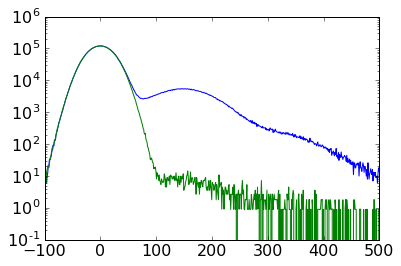

In [42]:
plt.plot(charge, LED_spectrum[0])
plt.plot(charge, noise_spectrum[0])
plt.xlim(-100, 500)
plt.yscale('log')
#plt.ylim(1e4, 3e4)
plt.show()

In [43]:
residual = LED_spectrum - noise_spectrum

In [53]:
from scipy.interpolate import UnivariateSpline

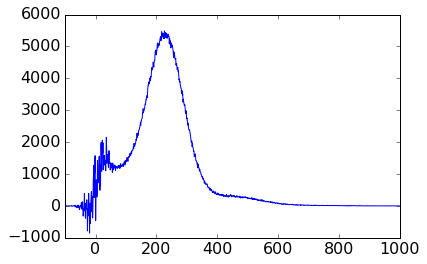

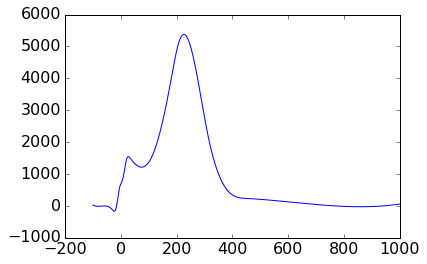

In [101]:
ch = 47
plt.plot(charge, residual[ch])
plt.xlim(-100, 1000)
plt.show()


test = residual[ch]
f = UnivariateSpline(charge, test, s=1.5e7)

plt.plot(charge, f(charge))
plt.show()

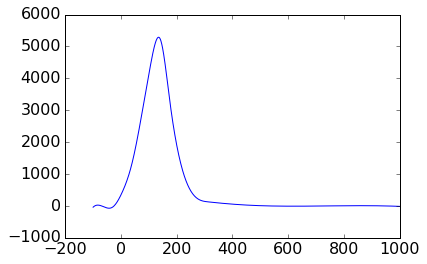

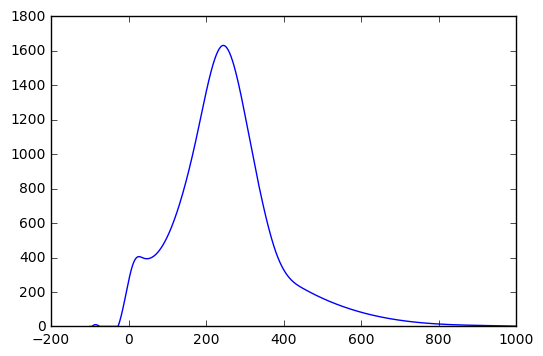

In [201]:
spe_dist = f(charge)
spe_dist = spe_dist.clip(min=0)
plt.plot(charge, spe_dist)
plt.show()

In [203]:
from scipy.optimize import curve_fit

def gauss(x, const, mu, sigma):
    G = const * np.exp(-(x-mu)**2 / (2*sigma**2))
    return G

def fit_with_gauss(xdata, ydata, xmin, xmax, first_guess = None):
    fit_xdata = [x for x in xdata if xmin<x<xmax]
    fit_ydata = [y for i,y in enumerate(ydata) if xmin<xdata[i]<xmax]
    assert len(fit_xdata) == len(fit_ydata)
    par_bounds = ([0, -np.inf, 0], [np.inf, np.inf, np.inf])
    pars, cov = curve_fit(gauss, fit_xdata, fit_ydata, first_guess, bounds = par_bounds)
    return pars, cov

[ 1620.60627188   244.29752363    76.18515467]


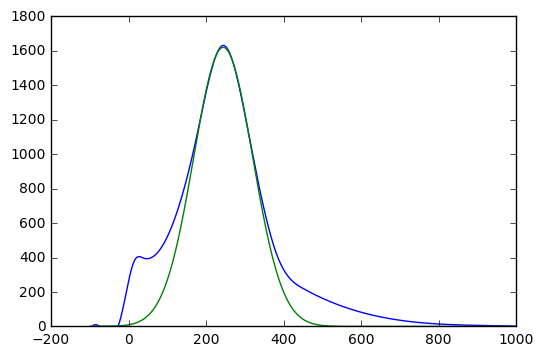

In [212]:
first_guess = [1e3, 250, 50]
popt,pcov = fit_with_gauss(charge,spe_dist, 175, 325, first_guess=first_guess)

print(popt)
fit = [gauss(x, *popt) for x in charge]
plt.plot(charge, spe_dist)
plt.plot(charge, fit)
plt.show()

In [237]:
new_spe = []
for i, (b, spe) in enumerate(zip(charge,spe_dist)):
    if b<popt[1]+popt[2]:
        if b<-50:
            new_spe.append(0.0)
        else:
            new_spe.append(spe)
    else:
        new_spe.append(fit[i])
        
new_spe = np.array(new_spe)


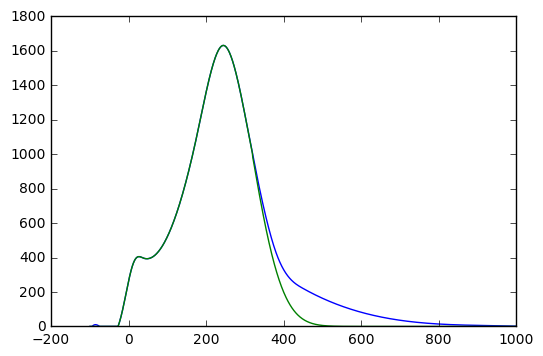

In [245]:
plt.plot(charge, spe_dist)
plt.plot(charge, new_spe)
plt.show()

In [239]:
spe = new_spe
spe = spe / spe.sum()
print(spe.sum())

1.0


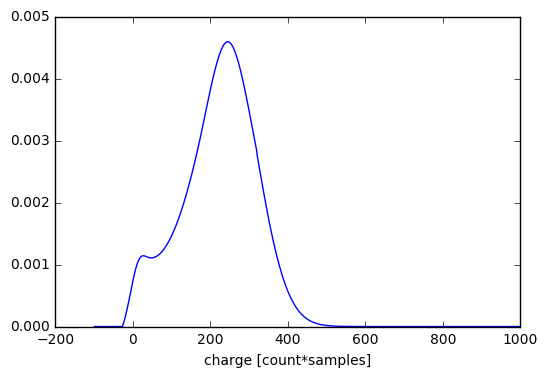

In [244]:
plt.plot(charge, spe)
plt.xlabel('charge [count*samples]')
plt.savefig('sample_spe_dist.png')
plt.show()

In [241]:
with open('spe_distribution.csv', "w") as f:
    for c, p in zip(charge, spe):
        f.write("%0.1f, %0.6f\n" % (c,p)) 